6개 짜리 데이터면 4개학습-1개맞추기 or 5개학습-1개 맞추기로 인원을 아예 나눠서 카운팅해보기

In [11]:
sum(df_sam2.groupby(['PID','Eye']).count()[df_sam2.groupby(['PID','Eye']).count()>=5]['AGE'].dropna()-4)

157.0

In [12]:
sum(df_sam2.groupby(['PID','Eye']).count()[df_sam2.groupby(['PID','Eye']).count()>=6]['AGE'].dropna()-5)

113.0

## 데이터 처리 환경설정

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, LassoLars, BayesianRidge
from sklearn.linear_model import OrthogonalMatchingPursuit, Lars, ARDRegression

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

import datetime as dt
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [10, 8]

from heat import rgb

In [2]:
print('Sklearn version: {}'.format(sklearn.__version__))
print('Opencv version: {}'.format(cv2.__version__))

Sklearn version: 0.24.1
Opencv version: 4.4.0


In [3]:
pd.set_option('display.float_format', None)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

### 데이터 불러오기

In [4]:
df_sam2_ori = pd.read_csv('./data/want_data.csv')

In [5]:
df_sam2 = df_sam2_ori.sort_values(['PID', 'AGE']).copy()

In [6]:
df_sam2.head(3)

,PID,AGE,Eye,Exam Date,Exam ID,Pupil diameter,False positive percent,False negative percent,Fixation loss,Fixation trial,Exam duration(min),GHT,MD,MD probability,PSD,PSD probability,VFI,PDP_01,PDP_02,PDP_03,PDP_04,PDP_05,PDP_06,PDP_07,PDP_08,PDP_09,PDP_10,PDP_11,PDP_12,PDP_13,PDP_14,PDP_15,PDP_16,PDP_17,PDP_18,PDP_19,PDP_20,PDP_21,PDP_22,PDP_23,PDP_24,PDP_25,PDP_26,PDP_27,PDP_28,PDP_29,PDP_30,PDP_31,PDP_32,PDP_33,...,mythv_5,mythv_6,mythv_7,mythv_8,mythv_9,mythv_10,mythv_11,mythv_12,mythv_13,mythv_14,mythv_15,mythv_16,mythv_17,mythv_18,mythv_19,mythv_20,mythv_21,mythv_22,mythv_23,mythv_24,mythv_25,mythv_26,mythv_27,mythv_28,mythv_29,mythv_30,mythv_31,mythv_32,mythv_33,mythv_34,mythv_35,mythv_36,mythv_37,mythv_38,mythv_39,mythv_40,mythv_41,mythv_42,mythv_43,mythv_44,mythv_45,mythv_46,mythv_47,mythv_48,mythv_49,mythv_50,mythv_51,mythv_52,mythv_53,mythv_54
0,2,51,OS,20101119,NaN,6.4,1,0,0,13,4,2,-0.98,0,1.54,0,98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3,0,0,NaN,0,0,3,0,0,0,0,...,28,31,30,30,31,30,29,30,31,32,30,30,28,29,27,28,29,29,29,32,31,NaN,29,27,24,29,30,32,30,29,NaN,31,27,31,31,33,31,30,32,29,29,31,31,31,30,30,27,30,30,30
1,2,51,OD,20101119,NaN,6.4,1,3,0,16,5,1,-1.82,1,1.62,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,...,34,30,27,27,25,29,26,30,30,31,30,28,30,27,28,28,29,29,30,30,29,NaN,27,22,27,29,30,32,32,30,NaN,24,30,30,30,30,30,30,29,29,30,29,29,28,30,30,28,28,30,28
2,2,52,OS,20111111,NaN,0.0,1,0,1,13,4,1,-0.51,0,1.27,0,100,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,...,29,31,29,28,31,27,28,32,32,32,32,30,28,30,31,31,30,30,31,32,32,NaN,29,31,31,30,27,30,31,29,NaN,31,30,31,30,32,31,27,28,31,32,32,27,29,30,27,29,30,31,29


In [7]:
df_sam2

,PID,AGE,Eye,Exam Date,Exam ID,Pupil diameter,False positive percent,False negative percent,Fixation loss,Fixation trial,Exam duration(min),GHT,MD,MD probability,PSD,PSD probability,VFI,PDP_01,PDP_02,PDP_03,PDP_04,PDP_05,PDP_06,PDP_07,PDP_08,PDP_09,PDP_10,PDP_11,PDP_12,PDP_13,PDP_14,PDP_15,PDP_16,PDP_17,PDP_18,PDP_19,PDP_20,PDP_21,PDP_22,PDP_23,PDP_24,PDP_25,PDP_26,PDP_27,PDP_28,PDP_29,PDP_30,PDP_31,PDP_32,PDP_33,...,mythv_5,mythv_6,mythv_7,mythv_8,mythv_9,mythv_10,mythv_11,mythv_12,mythv_13,mythv_14,mythv_15,mythv_16,mythv_17,mythv_18,mythv_19,mythv_20,mythv_21,mythv_22,mythv_23,mythv_24,mythv_25,mythv_26,mythv_27,mythv_28,mythv_29,mythv_30,mythv_31,mythv_32,mythv_33,mythv_34,mythv_35,mythv_36,mythv_37,mythv_38,mythv_39,mythv_40,mythv_41,mythv_42,mythv_43,mythv_44,mythv_45,mythv_46,mythv_47,mythv_48,mythv_49,mythv_50,mythv_51,mythv_52,mythv_53,mythv_54
0,2,51,OS,20101119,NaN,6.4,1,0,0,13,4,2,-0.98,0,1.54,0,98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3,0,0,NaN,0,0,3,0,0,0,0,...,28,31,30,30,31,30,29,30,31,32,30,30,28,29,27,28,29,29,29,32,31,NaN,29,27,24,29,30,32,30,29,NaN,31,27,31,31,33,31,30,32,29,29,31,31,31,30,30,27,30,30,30
1,2,51,OD,20101119,NaN,6.4,1,3,0,16,5,1,-1.82,1,1.62,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,...,34,30,27,27,25,29,26,30,30,31,30,28,30,27,28,28,29,29,30,30,29,NaN,27,22,27,29,30,32,32,30,NaN,24,30,30,30,30,30,30,29,29,30,29,29,28,30,30,28,28,30,28
2,2,52,OS,20111111,NaN,0.0,1,0,1,13,4,1,-0.51,0,1.27,0,100,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,...,29,31,29,28,31,27,28,32,32,32,32,30,28,30,31,31,30,30,31,32,32,NaN,29,31,31,30,27,30,31,29,NaN,31,30,31,30,32,31,27,28,31,32,32,27,29,30,27,29,30,31,29
3,2,52,OD,20111111,NaN,0.0,6,3,1,13,4,1,-0.44,0,1.67,0,99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,1,1,0,4,0,1,1,...,29,31,30,30,32,30,30,30,31,32,30,28,27,27,30,31,30,32,28,31,30,NaN,27,30,32,28,27,29,30,29,NaN,31,30,35,32,31,31,28,29,32,31,32,28,30,32,28,31,33,31,29
4,2,53,OS,20121031,NaN,3.9,0,0,2,14,4,1,-0.85,0,1.63,0,99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,NaN,0,0,0,0,0,0,0,...,30,29,30,28,33,29,30,30,31,31,32,32,30,27,24,28,30,31,31,31,27,NaN,27,26,30,32,31,31,31,27,NaN,30,31,30,31,31,32,30,26,29,29,31,30,28,30,28,31,30,29,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,258,64,OD,20050714,NaN,0.0,4,10,2,16,6,6,-5.25,5,2.45,3,95,0,4,2,0,0,1,0,0,0,0,0,0,0,0,0,3,1,1,1,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,...,26,22,25,25,25,23,26,27,28,28,25,12,15,21,20,21,26,27,21,28,26,NaN,22,27,26,25,22,24,25,28,NaN,26,26,25,24,22,27,23,26,28,28,27,16,26,28,25,27,24,24,27
369,258,65,OS,20060920,NaN,0.0,0,9,1,16,6,3,-8.97,5,4.30,5,91,0,4,4,0,0,0,1,0,0,0,0,0,0,0,0,4,4,2,2,4,1,0,0,0,0,NaN,3,0,0,0,0,0,0,...,21,20,17,25,22,15,24,24,24,24,21,0,0,17,16,11,20,20,17,23,22,NaN,15,24,24,23,18,20,23,23,NaN,25,24,25,24,23,22,16,22,23,25,24,22,22,22,19,24,23,19,22
370,258,65,OD,20060920,NaN,0.0,1,6,0,16,5,3,-7.17,5,4.55,5,93,0,4,4,0,0,3,0,0,0,0,0,0,0,0,0,4,4,3,0,3,0,0,1,0,0,NaN,0,0,0,0,0,0,0,...,21,18,21,23,23,21,23,25,26,27,23,0,0,18,21,14,25,23,18,24,24,NaN,25,24,25,25,23,24,25,25,NaN,26,26,25,24,20,24,22,25,25,28,26,23,24,26,26,26,25,22,21
371,258,66,OS,20071004,NaN,0.0,3,3,0,14,5,4,-4.21,5,1.68,0,98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,1,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,...,24,26,22,28,28,23,27,28,29,29,25,17,15,22,24,22,26,23,22,29,26,NaN,26,26,29,28,22,24,28,28,NaN,25,25,25,26,27,27,21,27,27,28,28,22,25,26,23,26,26,24,24


In [8]:
len(df_sam2['PID'].unique())

28

In [9]:
# 시드 고정
seed = 1996

우선 myTHV를 기준으로 작업해본다.

In [10]:
def show(want, method):
    total_rmse = []
    for i in want['PID'].unique():
        for j in want['Eye'].unique():
            sel_data = want[(want['PID']==i) & (want['Eye']==j)]
            rmse = []
            if len(sel_data)==0 : continue
            X = sel_data['Exam Date'].values.reshape(-1, 1)
            for k in range(52):
                y = sel_data.iloc[:,k+4].values
                X_train = X[:-1]
                X_test = X[-1].reshape(-1, 1)
                y_train = y[:-1]
                y_test = y[-1]

                line_fitter = method(fit_intercept=True, normalize=True)
                reg = line_fitter.fit(X_train, y_train)
                
                rmse.append((y_test - reg.predict(X_test))**2)
            total_rmse.append(np.sqrt(np.mean(rmse)))

    print("{}_RMSE: {:>15}".format(str(method).split('.')[-1], np.round(np.mean(total_rmse), 6)))

In [11]:
def show_CV(want, method):
    tscv = TimeSeriesSplit(n_splits = 3)
    total_rmse = []

    for i in want['PID'].unique():
        for j in want['Eye'].unique():
            rmse = []
            sel_data = want[(want['PID']==i) & (want['Eye']==j)]
            if len(sel_data)==0 : continue
            if (len(sel_data)==4) or (len(sel_data)==5):
                X = sel_data['Exam Date'].values.reshape(-1, 1)
                for k in range(52):
                    y = sel_data.iloc[:,k+4].values
                    X_train = X[:-1]
                    X_test = X[-1].reshape(-1, 1)
                    y_train = y[:-1]
                    y_test = y[-1]

                    line_fitter = method(fit_intercept=True, normalize=True)
                    reg = line_fitter.fit(X_train, y_train)
                    
                    rmse.append((y_test - reg.predict(X_test))**2)
                total_rmse.append(np.sqrt(np.mean(rmse)))

            elif (len(sel_data)>=6):
                X = sel_data['Exam Date'].values.reshape(-1, 1)
                for k in range(52):
                    y = sel_data.iloc[:,k+4].values
                    X_test = sel_data['Exam Date'].values[-1].reshape(-1, 1)
                    y_test = sel_data.iloc[:,4:].values[-1]
                    X_tr = sel_data['Exam Date'].values[:-1].reshape(-1, 1)
                    line_fitter = method(fit_intercept=True, normalize=True)
                    for train_index, test_index in tscv.split(X_tr):
                        X_train = X_tr[train_index]
                        y_train = y[train_index]
            #             scaler = MinMaxScaler()
            #             X_train_scaled = scaler.fit_transform(X_train)
            #             X_test_scaled = scaler.transform(X_test)
                        reg = line_fitter.fit(X_train, y_train)
            #             print('Accuracy on train data : {:.2f}'.format(reg.score(X_train, y_train)))
                #     print('Accuracy on test data : {:.2f}'.format(reg.score(X_test_scaled, y_test)))
                    rmse.append((y_test - reg.predict(X_test))**2)
                total_rmse.append(np.sqrt(np.mean(rmse)))
    #         print("RMSE: {}".format(np.mean(rmse)))
    print("{}_CV_RMSE: {:>12}".format(str(method).split('.')[-1], np.round(np.mean(total_rmse), 6)))

In [12]:
def show_DO(want, method):
    total_rmse = []

    for i in want['PID'].unique():
        for j in want['Eye'].unique():
            rmse = []
            sel_data = want[(want['PID']==i)&(want['Eye']==j)]
            if len(sel_data)==0 : continue
            if (len(sel_data)==4) or (len(sel_data)==5) : 
                X = sel_data['Exam Date'].values.reshape(-1, 1)
                for q in range(52):
                    y = sel_data.iloc[:,q+4].values
                    X_train = X[:-1]
                    X_test = X[-1].reshape(-1, 1)
                    y_train = y[:-1]
                    y_test = y[-1]

            #         scaler = MinMaxScaler()
                    line_fitter = method(fit_intercept=True, normalize=True)
                    reg = line_fitter.fit(X_train, y_train)
            #         print('Accuracy on train data : {:.2f}'.format(reg.score(X_train, y_train)))
            #         print('Accuracy on test data : {:.2f}'.format(reg.score(X_test, y_test)))

                    rmse.append((y_test - reg.predict(X_test))**2)
                total_rmse.append(np.sqrt(np.mean(rmse)))

            else :
                X_test = sel_data['Exam Date'].values[-1].reshape(-1, 1)
                for q in range(52):
                    y = sel_data.iloc[:,q+4].values
                    y_test = y[-1]
                    line_fitter = method(fit_intercept=True, normalize=True)
                    for k in range(len(sel_data)-5):
                        X_train = sel_data['Exam Date'][k:k+5][:-1].values.reshape(-1, 1)
                        y_train = y[k:k+5][:-1]

                        reg = line_fitter.fit(X_train, y_train)
                    rmse.append((y_test - reg.predict(X_test))**2)
                total_rmse.append(np.sqrt(np.mean(rmse)))

    print("{}_DO_RMSE: {:>12}".format(str(method).split('.')[-1], np.round(np.mean(total_rmse), 6)))

In [13]:
def show_RMSE(val, method):
    val_list = list(filter(lambda x : val in x, df_sam2.columns))
    val_list.pop(25)
    val_list.pop(33)
    want = df_sam2[['PID','AGE','Eye','Exam Date'] + val_list]
    want['Exam Date'] = pd.to_datetime(want['Exam Date'].apply(lambda x: str(x))).map(dt.datetime.toordinal)

    print(val, method)
    
    rmse = []
    show(want, method)
#     show_CV(want, method)
#     show_DO(want, method)

In [14]:
show_RMSE('THV', LinearRegression)
show_RMSE('THV', BayesianRidge)
show_RMSE('THV', LassoLars)
show_RMSE('THV', Ridge)
show_RMSE('THV', ElasticNet)
show_RMSE('THV', OrthogonalMatchingPursuit)
show_RMSE('THV', Lars)
show_RMSE('THV', ARDRegression)

THV <class 'sklearn.linear_model._base.LinearRegression'>
LinearRegression'>_RMSE:        6.864946
THV <class 'sklearn.linear_model._bayes.BayesianRidge'>
BayesianRidge'>_RMSE:        6.294804
THV <class 'sklearn.linear_model._least_angle.LassoLars'>
LassoLars'>_RMSE:        5.928451
THV <class 'sklearn.linear_model._ridge.Ridge'>
Ridge'>_RMSE:        5.545651
THV <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet'>_RMSE:         5.20033
THV <class 'sklearn.linear_model._omp.OrthogonalMatchingPursuit'>
OrthogonalMatchingPursuit'>_RMSE:        6.864946
THV <class 'sklearn.linear_model._least_angle.Lars'>
Lars'>_RMSE:        6.864946
THV <class 'sklearn.linear_model._bayes.ARDRegression'>
ARDRegression'>_RMSE:        6.294804


In [15]:
show_RMSE('PDP', Ridge)
show_RMSE('PDP', ElasticNet)
show_RMSE('PDP', LassoLars)

print()

show_RMSE('PDV', Ridge)
show_RMSE('PDV', ElasticNet)
show_RMSE('PDV', LassoLars)

print()

show_RMSE('THV', Ridge)
show_RMSE('THV', ElasticNet)
show_RMSE('THV', LassoLars)

print()

show_RMSE('TDV', Ridge)
show_RMSE('TDV', ElasticNet)
show_RMSE('TDV', LassoLars)

print()

show_RMSE('TDP', Ridge)
show_RMSE('TDP', ElasticNet)
show_RMSE('TDP', LassoLars)

print()

show_RMSE('mythv', Ridge)
show_RMSE('mythv', ElasticNet)
show_RMSE('mythv', LassoLars)

PDP <class 'sklearn.linear_model._ridge.Ridge'>
Ridge'>_RMSE:        1.285652
PDP <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet'>_RMSE:        1.155507
PDP <class 'sklearn.linear_model._least_angle.LassoLars'>
LassoLars'>_RMSE:        1.149059

PDV <class 'sklearn.linear_model._ridge.Ridge'>
Ridge'>_RMSE:        5.222436
PDV <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet'>_RMSE:        4.814688
PDV <class 'sklearn.linear_model._least_angle.LassoLars'>
LassoLars'>_RMSE:        5.539741

THV <class 'sklearn.linear_model._ridge.Ridge'>
Ridge'>_RMSE:        5.545651
THV <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet'>_RMSE:         5.20033
THV <class 'sklearn.linear_model._least_angle.LassoLars'>
LassoLars'>_RMSE:        5.928451

TDV <class 'sklearn.linear_model._ridge.Ridge'>
Ridge'>_RMSE:        5.494321
TDV <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
ElasticNet'>_RMSE:        5.154242
TDV <

## 훈련 결과
* value마다, 기법마다, 훈련 방법마다 모두 달랐지만 **ElasticNet, show함수**가 가장 효과적
    * show : Test셋 제외 전체를 학습시키는 것

In [16]:
val_list = list(filter(lambda x : 'THV' in x, df_sam2.columns))
val_list.pop(25)
val_list.pop(33)
want = df_sam2[['PID','AGE','Eye','Exam Date'] + val_list]
want['Exam Date'] = pd.to_datetime(want['Exam Date'].apply(lambda x: str(x))).map(dt.datetime.toordinal)

In [17]:
predict_THV = ['predict_THV'+str(i) for i in range(1, 55)]
predict_THV.pop(25)
predict_THV.pop(33)

'predict_THV35'

In [18]:
test = pd.Series()
p = 0
for i in want['PID'].unique():
    for j in want['Eye'].unique():
        sel_data = want[(want['PID']==i)&(want['Eye']==j)]
        if len(sel_data) == 0 : continue
        if len(test) == 0 : 
            test =  sel_data.iloc[-1]
            p+=1
        else : 
            test = pd.concat([test, sel_data.iloc[-1]], axis=1)
            p+=1
            
test = test.T

In [19]:
total_rmse = [[] for i in range(54)]
num_ind = 0
for i in want['PID'].unique():
    for j in want['Eye'].unique():
        sel_data = want[(want['PID']==i) & (want['Eye']==j)]
        rmse = []
        if len(sel_data)==0 : continue
        X = sel_data['Exam Date'].values.reshape(-1, 1)
        for k in range(52):
            y = sel_data.iloc[:,k+4].values
            X_train = X[:-1]
            X_test = X[-1].reshape(-1, 1)
            y_train = y[:-1]
            y_test = y[-1]

            line_fitter = ElasticNet(fit_intercept=True, normalize=True)
            reg = line_fitter.fit(X_train, y_train)

            rmse.append(np.round(reg.predict(X_test)[0], 0))
        total_rmse[num_ind] = np.round(rmse, 0)
        num_ind +=1

In [20]:
predict_df = pd.DataFrame(total_rmse, columns=predict_THV, index = test.index)
test_predict = pd.concat([test, predict_df], axis=1)

In [21]:
test_predict.head()

,PID,AGE,Eye,Exam Date,THV_01,THV_02,THV_03,THV_04,THV_05,THV_06,THV_07,THV_08,THV_09,THV_10,THV_11,THV_12,THV_13,THV_14,THV_15,THV_16,THV_17,THV_18,THV_19,THV_20,THV_21,THV_22,THV_23,THV_24,THV_25,THV_27,THV_28,THV_29,THV_30,THV_31,THV_32,THV_33,THV_34,THV_36,THV_37,THV_38,THV_39,THV_40,THV_41,THV_42,THV_43,THV_44,THV_45,THV_46,THV_47,THV_48,...,predict_THV3,predict_THV4,predict_THV5,predict_THV6,predict_THV7,predict_THV8,predict_THV9,predict_THV10,predict_THV11,predict_THV12,predict_THV13,predict_THV14,predict_THV15,predict_THV16,predict_THV17,predict_THV18,predict_THV19,predict_THV20,predict_THV21,predict_THV22,predict_THV23,predict_THV24,predict_THV25,predict_THV27,predict_THV28,predict_THV29,predict_THV30,predict_THV31,predict_THV32,predict_THV33,predict_THV34,predict_THV36,predict_THV37,predict_THV38,predict_THV39,predict_THV40,predict_THV41,predict_THV42,predict_THV43,predict_THV44,predict_THV45,predict_THV46,predict_THV47,predict_THV48,predict_THV49,predict_THV50,predict_THV51,predict_THV52,predict_THV53,predict_THV54
12,2,58,OS,736626,27,25,28,29,29,29,29,29,31,30,28,31,29,32,32,31,32,29,29,30,31,30,33,33,28,29,29,29,32,31,31,32,32,28,30,29,31,31,31,32,28,29,30,31,28,32,...,26.0,30.0,28.0,30.0,29.0,29.0,31.0,28.0,30.0,31.0,31.0,32.0,31.0,29.0,29.0,29.0,28.0,29.0,30.0,30.0,31.0,32.0,30.0,29.0,29.0,30.0,31.0,29.0,30.0,31.0,30.0,31.0,30.0,31.0,30.0,31.0,31.0,29.0,30.0,30.0,30.0,31.0,29.0,30.0,31.0,30.0,29.0,30.0,29.0,29.0
13,2,58,OD,736626,27,26,29,29,22,30,30,27,29,29,28,30,31,32,30,30,25,30,29,29,32,31,31,29,31,28,23,29,32,31,31,31,31,30,31,32,32,31,30,30,28,26,25,31,28,32,...,28.0,28.0,31.0,30.0,29.0,29.0,29.0,29.0,29.0,31.0,31.0,32.0,30.0,30.0,29.0,28.0,29.0,31.0,30.0,31.0,30.0,31.0,31.0,28.0,29.0,30.0,30.0,28.0,29.0,31.0,30.0,29.0,30.0,31.0,31.0,31.0,30.0,30.0,30.0,30.0,32.0,31.0,29.0,30.0,31.0,32.0,29.0,30.0,30.0,30.0
19,9,79,OS,736618,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,5,23,22,28,2,2,2,2,2,2,2,2,2,2,2,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,0.0,1.0,1.0,1.0,2.0,18.0,12.0,17.0,0.0,0.0,0.0,0.0,1.0,7.0,5.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
32,12,76,OS,736972,19,22,24,17,20,24,23,25,10,15,21,25,22,21,2,10,13,22,26,26,28,27,25,29,11,26,23,29,27,27,27,27,30,28,26,25,27,28,27,28,31,27,24,27,27,29,...,18.0,22.0,22.0,22.0,22.0,25.0,25.0,22.0,21.0,25.0,27.0,20.0,13.0,16.0,15.0,20.0,19.0,19.0,12.0,20.0,22.0,20.0,17.0,26.0,25.0,28.0,26.0,20.0,28.0,25.0,25.0,25.0,28.0,26.0,26.0,26.0,27.0,24.0,26.0,27.0,28.0,27.0,26.0,28.0,27.0,27.0,27.0,27.0,25.0,27.0
33,12,76,OD,736972,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,4,17,0,7,0,20,14,24,22,18,14,16,13,14,24,24,22,22,20,4,13,21,23,21,24,23,17,21,19,19,...,4.0,6.0,9.0,8.0,5.0,5.0,5.0,2.0,2.0,2.0,0.0,2.0,1.0,1.0,1.0,3.0,2.0,0.0,2.0,3.0,11.0,18.0,6.0,22.0,23.0,25.0,23.0,13.0,25.0,24.0,25.0,23.0,24.0,23.0,19.0,22.0,18.0,13.0,18.0,19.0,25.0,25.0,16.0,5.0,25.0,3.0,19.0,23.0,18.0,18.0


In [22]:
def show_predict(pid, eye):
    global vis_data, check_data
    check_list = []
    check_data = df_sam2[(df_sam2['PID']==pid)&(df_sam2['Eye']==eye)]
    vis_data = test_predict[(test_predict['PID']==pid)&(test_predict['Eye']==eye)]
    input_date = str(vis_data['Exam Date'])

    if vis_data['Eye'].iloc[0] == 'OS' : 
        visual_value = pd.DataFrame({input_date : [0.1]*144})
        ind_val = 0
        for i in range(72):
            if (i<2) or (6<=i<10) or (16<=i<18) or (i==26) or (53<=i<55) or (61<=i<65) or (69<=i):
                visual_value[input_date][i] = 0.1
            elif (i==34) or (i==43):
                visual_value[input_date][i] = np.nan
            else :
                visual_value[input_date][i] = vis_data.iloc[:,4:].values[0][ind_val]
                visual_value[input_date][i+72] = vis_data.iloc[:,4:].values[0][ind_val+52]
                ind_val += 1

    elif vis_data['Eye'].iloc[0] == 'OD': 
        visual_value = pd.DataFrame({input_date : [0.1]*144})
        ind_val = 0
        for i in range(72):
            if (i<3) or (7<=i<11) or (17<=i<19) or (i==45) or (54<=i<56) or (62<=i<66) or (70<=i):
                visual_value[input_date][i] = 0.1
            elif (i==28) or (i==37) :
                visual_value[input_date][i] = np.nan
            else :
                visual_value[input_date][i] = vis_data.iloc[:,4:].values[0][ind_val]
                visual_value[input_date][i+72] = vis_data.iloc[:,4:].values[0][ind_val+52]
                ind_val += 1

    use_val = visual_value.values
    img = np.zeros((400, 450, 3), np.uint8)

    ext_ind = 0
    num_ind = 0
    for i in range(72):
        if ext_ind == 0 :
            point1 = 50*i, 0
        else : point1 = 50*(i-9*ext_ind), 0+50*ext_ind
        point2 = point1[0]+50, point1[1]+50
        point3 = point1[0]+7, point1[1]+12
        point4 = point1[0]+7, point1[1]+27
        point5 = point1[0]+7, point1[1]+42
        point6 = point1[0]+35, point1[1]+8
        img = cv2.rectangle(img, point1, point2, rgb(min(use_val), max(use_val), use_val[i]), -1)
        img = cv2.putText(img, str(use_val[i][0]), point3, 16, 0.4, (255, 255, 255), thickness =2)
        if use_val[i+72][0] != 0.1:
            num_ind += 1 
            img = cv2.putText(img, str(use_val[i+72][0]), point4, 16, 0.4, (0, 0, 0), thickness =2)
            if abs(use_val[i][0] - use_val[i+72][0]) < 5:
                img = cv2.putText(img, str(use_val[i][0] - use_val[i+72][0]), point5, 16, 0.4, (189, 189, 189), thickness =2)
                img = cv2.putText(img, str(num_ind), point6, 6, 0.3, (0, 255, 255), thickness =2)
            else : 
                img = cv2.putText(img, str(use_val[i][0] - use_val[i+72][0]), point5, 16, 0.4, (255, 0, 255), thickness =2)
                img = cv2.putText(img, str(num_ind), point6, 6, 0.3, (255, 0, 255), thickness =2)
                check_list.append(num_ind)

        if np.isnan(use_val[i][0]) : 
            num_ind+=1
            img = cv2.putText(img, str(num_ind), point6, 6, 0.3, (255, 255, 255), thickness =2)

        if (i%9==8):
            ext_ind += 1

    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # cv2.imshow(input_date, imgRGB)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    print(check_list)

    plt.imshow(imgRGB)
    plt.show()

In [23]:
# pid, eye, value로 조건에 맞는 데이터 추출 - value는 thv, tdv를 의미
def filter_person(data ,pid, eye, value):
    pid_person = data[(data['PID']==pid) & (data['Eye']==eye)]
    part_list = list(filter(lambda x : value in x, pid_person.columns))
    
    global filter_data #global 데이터로 밖에서도 쓸 수 있게 선언
    filter_data = pid_person[['PID','AGE','Eye','Exam Date']+part_list]

In [24]:
def show_eye(data, pid, eye, value):
    # 원하는 환자의 검진날짜를 입력
    filter_person(data, pid, eye, value)
    print(list(filter_data['Exam Date']))

    input_date = input()
    vis_data = filter_data[filter_data['Exam Date']==int(input_date)]
    
    if vis_data['Eye'].iloc[0] == 'OS' : 
        visual_value = pd.DataFrame({input_date : [0.1]*72})
        ind_val = 0
        for i in range(72):
            if (i<2) or (6<=i<10) or (16<=i<18) or (i==26) or (53<=i<55) or (61<=i<65) or (69<=i):
                visual_value[input_date][i] = 0.1
            else :
                visual_value[input_date][i] = vis_data.iloc[:,-54:].values[0][ind_val]
                ind_val += 1
                
    elif vis_data['Eye'].iloc[0] == 'OD': 
        visual_value = pd.DataFrame({input_date : [0.1]*72})
        ind_val = 0
        for i in range(72):
            if (i<3) or (7<=i<11) or (17<=i<19) or (i==45) or (54<=i<56) or (62<=i<66) or (70<=i):
                visual_value[input_date][i] = 0.1
            else :
                visual_value[input_date][i] = vis_data.iloc[:,-54:].values[0][ind_val]
                ind_val += 1

    use_val = visual_value.values
    img = np.zeros((400, 450, 3), np.uint8)

    ext_ind = 0
    for i in range(72):
        if ext_ind == 0 :
            point1 = 50*i, 0
        else : point1 = 50*(i-9*ext_ind), 0+50*ext_ind
        point2 = point1[0]+50, point1[1]+50
        point3 = point1[0]+7, point1[1]+25
        img = cv2.rectangle(img, point1, point2, rgb(min(use_val), max(use_val), use_val[i]), -1)
        img = cv2.putText(img, str(use_val[i][0]), point3, 16, 0.4, (255, 255, 255), thickness =2)

        if (i%9==8):
            ext_ind += 1

    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # cv2.imshow(input_date, imgRGB)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    plt.imshow(imgRGB)
    plt.show()

## 마음에 안드는 데이터
* 9번 데이터가 개판임
* 마지막 검사에서 확 나빠진 경우를 예측을 못함

In [25]:
df_sam2['PID'].unique()

array([  2,   9,  12,  17,  19,  25,  41,  42,  43,  49,  55,  62,  74,
        76,  79,  90,  91,  98, 131, 136, 157, 165, 181, 190, 203, 251,
       257, 258], dtype=int64)

In [26]:
df_sam2

,PID,AGE,Eye,Exam Date,Exam ID,Pupil diameter,False positive percent,False negative percent,Fixation loss,Fixation trial,Exam duration(min),GHT,MD,MD probability,PSD,PSD probability,VFI,PDP_01,PDP_02,PDP_03,PDP_04,PDP_05,PDP_06,PDP_07,PDP_08,PDP_09,PDP_10,PDP_11,PDP_12,PDP_13,PDP_14,PDP_15,PDP_16,PDP_17,PDP_18,PDP_19,PDP_20,PDP_21,PDP_22,PDP_23,PDP_24,PDP_25,PDP_26,PDP_27,PDP_28,PDP_29,PDP_30,PDP_31,PDP_32,PDP_33,...,mythv_5,mythv_6,mythv_7,mythv_8,mythv_9,mythv_10,mythv_11,mythv_12,mythv_13,mythv_14,mythv_15,mythv_16,mythv_17,mythv_18,mythv_19,mythv_20,mythv_21,mythv_22,mythv_23,mythv_24,mythv_25,mythv_26,mythv_27,mythv_28,mythv_29,mythv_30,mythv_31,mythv_32,mythv_33,mythv_34,mythv_35,mythv_36,mythv_37,mythv_38,mythv_39,mythv_40,mythv_41,mythv_42,mythv_43,mythv_44,mythv_45,mythv_46,mythv_47,mythv_48,mythv_49,mythv_50,mythv_51,mythv_52,mythv_53,mythv_54
0,2,51,OS,20101119,NaN,6.4,1,0,0,13,4,2,-0.98,0,1.54,0,98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3,0,0,NaN,0,0,3,0,0,0,0,...,28,31,30,30,31,30,29,30,31,32,30,30,28,29,27,28,29,29,29,32,31,NaN,29,27,24,29,30,32,30,29,NaN,31,27,31,31,33,31,30,32,29,29,31,31,31,30,30,27,30,30,30
1,2,51,OD,20101119,NaN,6.4,1,3,0,16,5,1,-1.82,1,1.62,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,...,34,30,27,27,25,29,26,30,30,31,30,28,30,27,28,28,29,29,30,30,29,NaN,27,22,27,29,30,32,32,30,NaN,24,30,30,30,30,30,30,29,29,30,29,29,28,30,30,28,28,30,28
2,2,52,OS,20111111,NaN,0.0,1,0,1,13,4,1,-0.51,0,1.27,0,100,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,...,29,31,29,28,31,27,28,32,32,32,32,30,28,30,31,31,30,30,31,32,32,NaN,29,31,31,30,27,30,31,29,NaN,31,30,31,30,32,31,27,28,31,32,32,27,29,30,27,29,30,31,29
3,2,52,OD,20111111,NaN,0.0,6,3,1,13,4,1,-0.44,0,1.67,0,99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,NaN,1,1,0,4,0,1,1,...,29,31,30,30,32,30,30,30,31,32,30,28,27,27,30,31,30,32,28,31,30,NaN,27,30,32,28,27,29,30,29,NaN,31,30,35,32,31,31,28,29,32,31,32,28,30,32,28,31,33,31,29
4,2,53,OS,20121031,NaN,3.9,0,0,2,14,4,1,-0.85,0,1.63,0,99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,NaN,0,0,0,0,0,0,0,...,30,29,30,28,33,29,30,30,31,31,32,32,30,27,24,28,30,31,31,31,27,NaN,27,26,30,32,31,31,31,27,NaN,30,31,30,31,31,32,30,26,29,29,31,30,28,30,28,31,30,29,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,258,64,OD,20050714,NaN,0.0,4,10,2,16,6,6,-5.25,5,2.45,3,95,0,4,2,0,0,1,0,0,0,0,0,0,0,0,0,3,1,1,1,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,...,26,22,25,25,25,23,26,27,28,28,25,12,15,21,20,21,26,27,21,28,26,NaN,22,27,26,25,22,24,25,28,NaN,26,26,25,24,22,27,23,26,28,28,27,16,26,28,25,27,24,24,27
369,258,65,OS,20060920,NaN,0.0,0,9,1,16,6,3,-8.97,5,4.30,5,91,0,4,4,0,0,0,1,0,0,0,0,0,0,0,0,4,4,2,2,4,1,0,0,0,0,NaN,3,0,0,0,0,0,0,...,21,20,17,25,22,15,24,24,24,24,21,0,0,17,16,11,20,20,17,23,22,NaN,15,24,24,23,18,20,23,23,NaN,25,24,25,24,23,22,16,22,23,25,24,22,22,22,19,24,23,19,22
370,258,65,OD,20060920,NaN,0.0,1,6,0,16,5,3,-7.17,5,4.55,5,93,0,4,4,0,0,3,0,0,0,0,0,0,0,0,0,4,4,3,0,3,0,0,1,0,0,NaN,0,0,0,0,0,0,0,...,21,18,21,23,23,21,23,25,26,27,23,0,0,18,21,14,25,23,18,24,24,NaN,25,24,25,25,23,24,25,25,NaN,26,26,25,24,20,24,22,25,25,28,26,23,24,26,26,26,25,22,21
371,258,66,OS,20071004,NaN,0.0,3,3,0,14,5,4,-4.21,5,1.68,0,98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,1,0,0,0,0,0,0,0,NaN,0,0,0,0,0,0,0,...,24,26,22,28,28,23,27,28,29,29,25,17,15,22,24,22,26,23,22,29,26,NaN,26,26,29,28,22,24,28,28,NaN,25,25,25,26,27,27,21,27,27,28,28,22,25,26,23,26,26,24,24


In [27]:
show_predict(9, 'OD')

IndexError: single positional indexer is out-of-bounds

In [ ]:
check_data['TDV_01']

[20120607, 20130705, 20141007, 20151008, 20161020, 20171016]
20171016


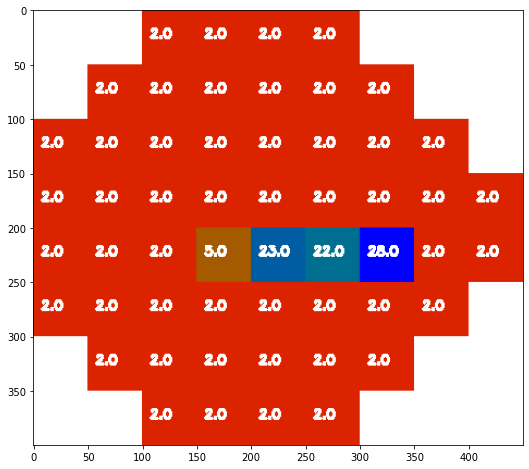

In [34]:
show_eye(df_sam2, 9, 'OS', 'THV')

In [ ]:
t

In [ ]:
val_list = list(filter(lambda x : 'mythv' in x, df_sam2.columns))
val_list.pop(25)
val_list.pop(33)
want = df_sam2[['PID','AGE','Eye','Exam Date'] + val_list]
want['Exam Date'] = pd.to_datetime(want['Exam Date'].apply(lambda x: str(x))).map(dt.datetime.toordinal)

* LinearRegression을 여러가지 방법으로 시도해봤다
    * MinMaxScaler는 별 의미가 없음

다른 작업 없이 마지막 검사결과를 맞추기 위해 앞의 데이터 전체 학습
* 사람별, 눈별 예측했고 전체의 RMSE 오차 평균 구함
    * 데이터가 적을 수 있다는 단점이 있음

In [ ]:
rmse = []

for i in want['PID'].unique():
    for j in want['Eye'].unique():
        sel_data = want[(want['PID']==i)&(want['Eye']==j)]
        if len(sel_data)==0 : continue
        X = sel_data['Exam Date'].values.reshape(-1, 1)
        y = sel_data.iloc[:,4:].values
        X_train = X[:-1]
        X_test = X[-1].reshape(-1, 1)
        y_train = y[:-1]
        y_test = y[-1]
#         scaler = MinMaxScaler()
        line_fitter = LinearRegression(fit_intercept=True, normalize=True, n_jobs=-1)
        reg = line_fitter.fit(X_train, y_train)
#         print('Accuracy on train data : {:.2f}'.format(reg.score(X_train, y_train)))
#         print('Accuracy on test data : {:.2f}'.format(reg.score(X_test, y_test)))

        rmse.append(np.sqrt(mean_squared_error(y_test, reg.predict(X_test)[0])))
#         print(reg.coef_, reg.intercept_)

#         print("RMSE: {}".format(np.mean(rmse)))
print("Method1_RMSE: {}".format(np.mean(rmse)))

Cross-validation한 결과
* TimeSeriesSplit을 이용했고, 데이터가 4개나 5개 있을 경우 과적합이 이루어질 수 있음

In [ ]:
tscv = TimeSeriesSplit(n_splits = 3)
rmse = []

for i in want['PID'].unique():
    for j in want['Eye'].unique():
        sel_data = want[(want['PID']==i)&(want['Eye']==j)]
        if len(sel_data)==0 : continue
        if (len(sel_data)==4) or (len(sel_data)==5) : 
            X = sel_data['Exam Date'].values.reshape(-1, 1)
            y = sel_data.iloc[:,4:].values
            X_train = X[:-1]
            X_test = X[-1].reshape(-1, 1)
            y_train = y[:-1]
            y_test = y[-1]

    #         scaler = MinMaxScaler()
            line_fitter = LinearRegression(fit_intercept=True, normalize=True, n_jobs=-1)
            reg = line_fitter.fit(X_train, y_train)
    #         print('Accuracy on train data : {:.2f}'.format(reg.score(X_train, y_train)))
    #         print('Accuracy on test data : {:.2f}'.format(reg.score(X_test, y_test)))

            rmse.append(np.sqrt(mean_squared_error(y_test, reg.predict(X_test)[0])))
        
        elif (len(sel_data)>=6):
        
            X = sel_data['Exam Date'].values.reshape(-1, 1)
            y = sel_data.iloc[:,4:].values
            X_test = sel_data['Exam Date'].values[-1].reshape(-1, 1)
            y_test = sel_data.iloc[:,4:].values[-1]
            X_tr = sel_data['Exam Date'].values[:-1].reshape(-1, 1)
            line_fitter = LinearRegression(fit_intercept=True, normalize=True, n_jobs=-1)
            for train_index, test_index in tscv.split(X_tr):
                X_train = X_tr[train_index]
                y_train = y[train_index]

    #             scaler = MinMaxScaler()
    #             X_train_scaled = scaler.fit_transform(X_train)
    #             X_test_scaled = scaler.transform(X_test)

                reg = line_fitter.fit(X_train, y_train)
    #             print('Accuracy on train data : {:.2f}'.format(reg.score(X_train, y_train)))
            #     print('Accuracy on test data : {:.2f}'.format(reg.score(X_test_scaled, y_test)))

            rmse.append(np.sqrt(mean_squared_error(y_test, reg.predict(X_test)[0])))

#         print("RMSE: {}".format(np.mean(rmse)))
print("Method2_RMSE: {}".format(np.mean(rmse)))

* 데이터가 4개나 5개 이상일 경우 5개씩 새로운 그룹으로 묶어 학습시키는 데이터의 양을 증가시켜줌
    * 오차가 오히려 커짐

In [ ]:
rmse = []

for i in want['PID'].unique():
    for j in want['Eye'].unique():
        sel_data = want[(want['PID']==i)&(want['Eye']==j)]
        if len(sel_data)==0 : continue
        if (len(sel_data)==4) or (len(sel_data)==5) : 
            X = sel_data['Exam Date'].values.reshape(-1, 1)
            y = sel_data.iloc[:,4:].values
            X_train = X[:-1]
            X_test = X[-1].reshape(-1, 1)
            y_train = y[:-1]
            y_test = y[-1]

    #         scaler = MinMaxScaler()
            line_fitter = LinearRegression(fit_intercept=True, normalize=True, n_jobs=-1)
            reg = line_fitter.fit(X_train, y_train)
    #         print('Accuracy on train data : {:.2f}'.format(reg.score(X_train, y_train)))
    #         print('Accuracy on test data : {:.2f}'.format(reg.score(X_test, y_test)))

            rmse.append(np.sqrt(mean_squared_error(y_test, reg.predict(X_test)[0])))
            
        else :
            X_test = sel_data['Exam Date'].values[-1].reshape(-1, 1)
            y_test = sel_data.iloc[:,4:].values[-1]
            line_fitter = LinearRegression(fit_intercept=True, normalize=True, n_jobs=-1)
            for i in range(len(sel_data)-5):
                use_data = sel_data.iloc[i:i+5]
                X = use_data['Exam Date'].values.reshape(-1, 1)
                y = use_data.iloc[:,4:].values
                X_train = X[:-1]
                y_train = y[:-1]
                
                reg = line_fitter.fit(X_train, y_train)
            rmse.append(np.sqrt(mean_squared_error(y_test, reg.predict(X_test)[0])))

print("Method3_RMSE: {}".format(np.mean(rmse)))